### Capstone project on classification modelling

##### importing dependencies

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer 
from sklearn.metrics import roc_auc_score, precision_score, recall_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [16]:
# bringing in dataset into DataFrame
data = pd.read_csv("Train_data.csv")

In [5]:
# Printing first 5 rows
data.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,.,1053,0
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0


In [6]:
# Examining number of rows and columns
data.shape

(7160, 14)

In [7]:
# Getting summaries of the numerical columns
data.describe()

,YearOfObservation,Insured_Period,Residential,Building Dimension,Building_Type,Date_of_Occupancy,Claim
count,7160.000000,7160.000000,7160.000000,7054.000000,7160.000000,6652.000000,7160.000000
mean,2013.669553,0.909758,0.305447,1883.727530,2.186034,1964.456404,0.228212
std,1.383769,0.239756,0.460629,2278.157745,0.940632,36.002014,0.419709
min,2012.000000,0.000000,0.000000,1.000000,1.000000,1545.000000,0.000000
25%,2012.000000,0.997268,0.000000,528.000000,2.000000,1960.000000,0.000000
50%,2013.000000,1.000000,0.000000,1083.000000,2.000000,1970.000000,0.000000
75%,2015.000000,1.000000,1.000000,2289.750000,3.000000,1980.000000,0.000000
max,2016.000000,1.000000,1.000000,20940.000000,4.000000,2016.000000,1.000000


In [8]:
# Examining basic information, missing values and data types
# Missing values in Garden, building dimensions, data of occupancy and geo code
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         7160 non-null   object 
 1   YearOfObservation   7160 non-null   int64  
 2   Insured_Period      7160 non-null   float64
 3   Residential         7160 non-null   int64  
 4   Building_Painted    7160 non-null   object 
 5   Building_Fenced     7160 non-null   object 
 6   Garden              7153 non-null   object 
 7   Settlement          7160 non-null   object 
 8   Building Dimension  7054 non-null   float64
 9   Building_Type       7160 non-null   int64  
 10  Date_of_Occupancy   6652 non-null   float64
 11  NumberOfWindows     7160 non-null   object 
 12  Geo_Code            7058 non-null   object 
 13  Claim               7160 non-null   int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 783.3+ KB


#### Data cleaning and preparation

In [9]:
# Checking for missing values
data.isna().sum()
# Missing values: Garden (7), building dimension (106), date of occupancy (508) and Geo code (102)
# We now have 3551 rows with missing numbers in Number of Windows field

Customer Id             0
YearOfObservation       0
Insured_Period          0
Residential             0
Building_Painted        0
Building_Fenced         0
Garden                  7
Settlement              0
Building Dimension    106
Building_Type           0
Date_of_Occupancy     508
NumberOfWindows         0
Geo_Code              102
Claim                   0
dtype: int64

In [17]:
#To replace rows with dots as nissing to enable filling with mean
data["NumberOfWindows"] = data["NumberOfWindows"].replace(".", np.nan)


In [18]:
#To replace >=10 with 10. This is to enable conversion from string to numeric.
data["NumberOfWindows"] = data["NumberOfWindows"].str.replace(">=", " ", regex=False)


In [19]:
## Convert the Number of windows column to numeric type
data["NumberOfWindows"] = pd.to_numeric(
    data["NumberOfWindows"], errors="coerce"
)


In [160]:
## Fill missing values with the mean on the Number of Windows
data["NumberOfWindows"] = data["NumberOfWindows"].fillna(
    data["NumberOfWindows"].mean()
)
data["NumberOfWindows"] = data["NumberOfWindows"].round().astype(int)

In [20]:
# Examining the newly updated Number of Windows
window_counts=data["NumberOfWindows"].value_counts()
window_counts

NumberOfWindows
4.0     939
3.0     844
5.0     639
2.0     363
6.0     306
7.0     211
8.0     116
1.0      75
10.0     67
9.0      49
Name: count, dtype: int64

In [21]:
# Calculate number of years house has been from this year
# Age of house was engineered by subtracting the year of first occupancy from the current year to capture depreciation effects and building age influence on price
data["Age_of_house"]= data["YearOfObservation"]-data["Date_of_Occupancy"]

In [22]:
data['Age_of_house'].isna().sum()
# Has 508 vacant ages

np.int64(508)

In [23]:
## Filling missing values with the mean of age of house
data["Age_of_house"] = data["Age_of_house"].fillna(
    data["Age_of_house"].mean()
)
data["Age_of_house"] = data["Age_of_house"].round().astype(int) #convert to integer

In [24]:
data['Age_of_house'].isna().sum()
# Has 0 vacant age of houses

np.int64(0)

In [ ]:
# Cleaning the Building  Dimension column

In [168]:
data['Building Dimension'].isna().sum()
# Has 106 missing building dimensions

np.int64(106)

In [25]:
# Filling the building dimension with mean of the column.
data["Building Dimension"] = data["Building Dimension"].fillna(
    data["Building Dimension"].mean()
)
data["Building Dimension"] = data["Building Dimension"].round().astype(int) # Converting to integer

In [26]:
data['Building Dimension'].isna().sum()
# Has 0 missing building dimensions

np.int64(0)

In [171]:
# Cleaning the Geo code columns
data['Geo_Code'].isna().sum()
# Has 106 missing building dimensions

np.int64(102)

In [27]:
# Filling the missing rows in the Geo Code field
data["Geo_Code"] = data["Geo_Code"].fillna("Unknown")
# Missing location itself may carry risk
# Avoids injecting false geography so usng mode may mislead a model

In [28]:
# Filling the missing values in the Garden field
data["Garden"] = data["Garden"].fillna("Unknown")


In [ ]:
#Date of occupancy will be dropped eventually so it was not filled

#### Examining outliers

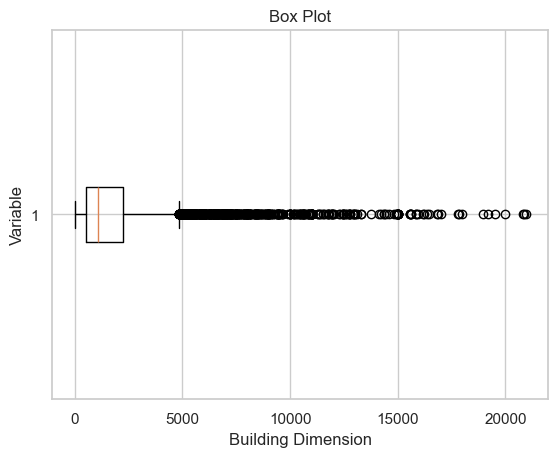

In [112]:
# This might skew the model
plt.boxplot(data['Building Dimension'], vert = False) #vert = false shows it in sideways
plt.ylabel('Variable')
plt.xlabel('Building Dimension')
plt.title('Box Plot')
plt.show()

In [9]:
###  Assessing for duplicates
data.duplicated().sum()

np.int64(0)

##### Data Visualization

##### 1. Calculating the claim against year of observation.

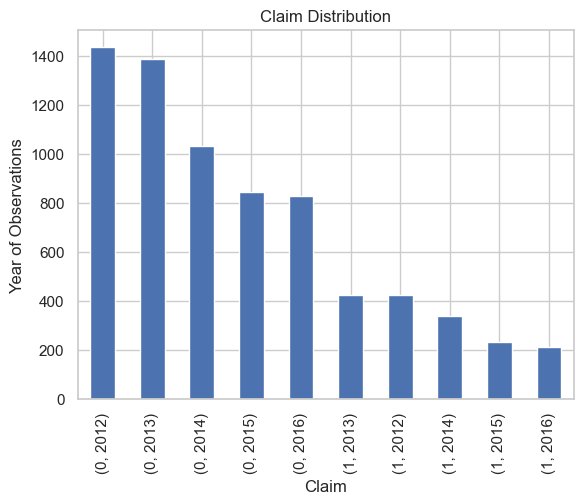

In [30]:
### Calculating the claim against year of observation.
claim_by_year=data.groupby("Claim")["YearOfObservation"].value_counts()

# Plotting status counts
claim_by_year.plot(kind='bar')
plt.title("Claim Distribution")
plt.ylabel("Year of Observations")
plt.xlabel("Claim")
plt.show()


##### 2. Claim Rate by Year of Observation

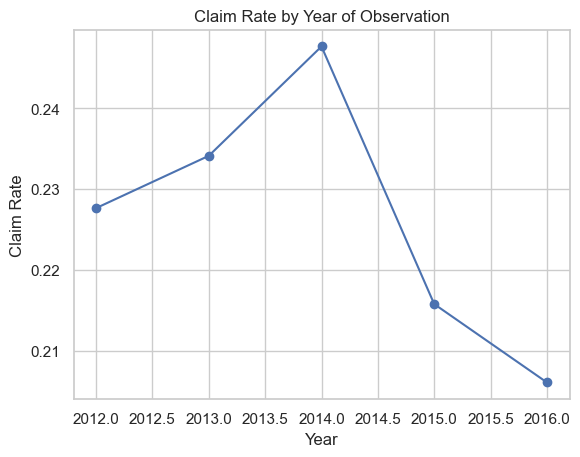

In [31]:

claim_year = data.groupby("YearOfObservation")["Claim"].mean()

plt.figure()
claim_year.plot(kind="line", marker="o")
plt.title("Claim Rate by Year of Observation")
plt.ylabel("Claim Rate")
plt.xlabel("Year")
plt.show()


##### 3. Claim Distribution (Accesing for balance/ Imbalance)

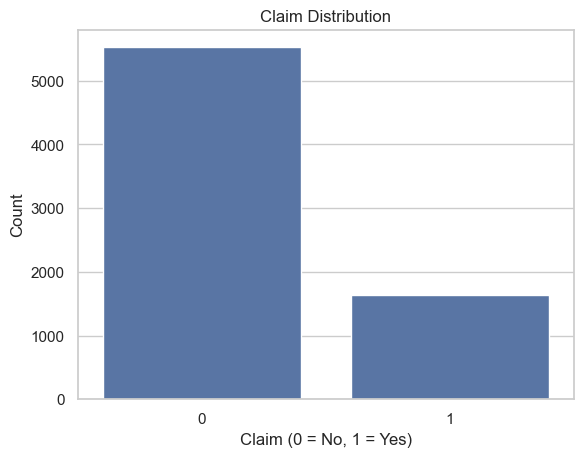

In [32]:
plt.figure()
sns.countplot(x="Claim", data=data)
plt.title("Claim Distribution")
plt.xlabel("Claim (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()


##### 4. Claim Rate by Residential Status

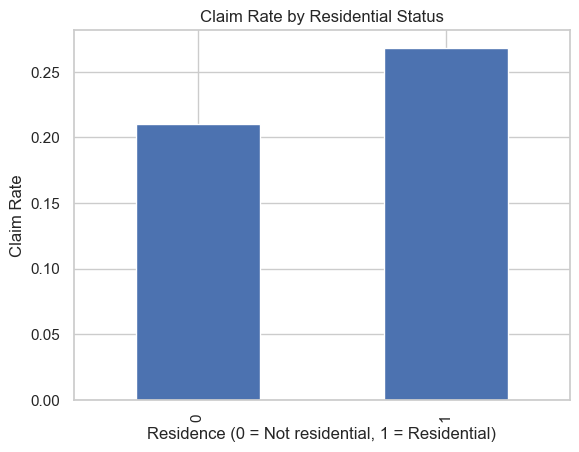

In [180]:
res_claim = data.groupby("Residential")["Claim"].mean()

plt.figure()
res_claim.plot(kind="bar")
plt.title("Claim Rate by Residential Status")
plt.ylabel("Claim Rate")
plt.xlabel("Residence (0 = Not residential, 1 = Residential)")
plt.show()


##### 5. Claim Rate by Building Type

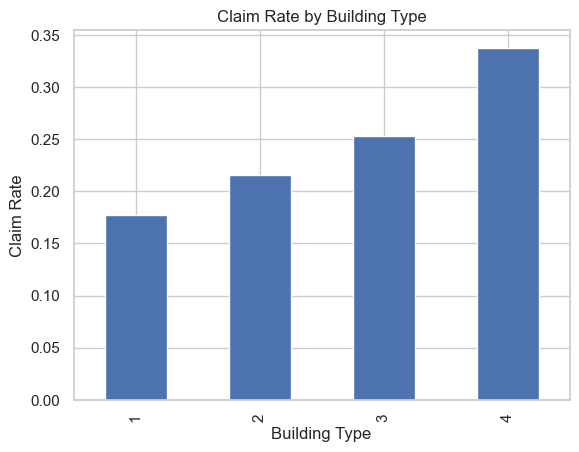

In [181]:
btype_claim = data.groupby("Building_Type")["Claim"].mean()

plt.figure()
btype_claim.plot(kind="bar")
plt.title("Claim Rate by Building Type")
plt.ylabel("Claim Rate")
plt.xlabel("Building Type")
plt.show()


##### 6. Claim Rate by Building Age

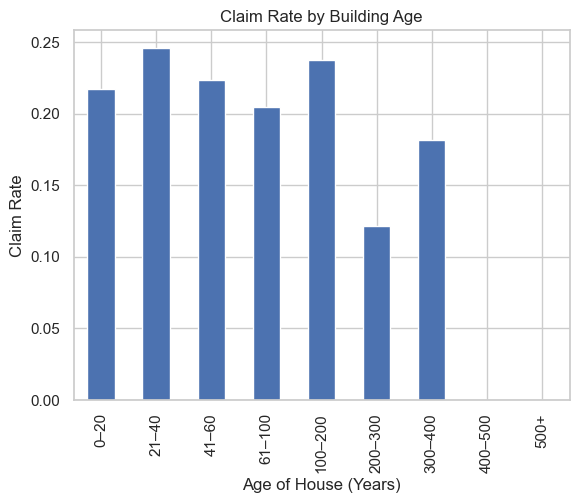

In [33]:
### Creating a class for the age_of house columns
data["Age_Band"] = pd.cut(
    data["Age_of_house"],
    bins=[0, 20, 40, 60, 100, 200, 300, 400, 500, np.inf],
    labels=[
        "0–20", "21–40", "41–60", "61–100",
        "100–200", "200–300", "300–400", "400–500", "500+"
    ],
    include_lowest=True
)

age_claim = data.groupby("Age_Band")["Claim"].mean()
# Plotting the claim rate by building age class
plt.figure()
age_claim.plot(kind="bar")
plt.title("Claim Rate by Building Age")
plt.ylabel("Claim Rate")
plt.xlabel("Age of House (Years)")
plt.show()


#####  7. Number of Windows vs Claim

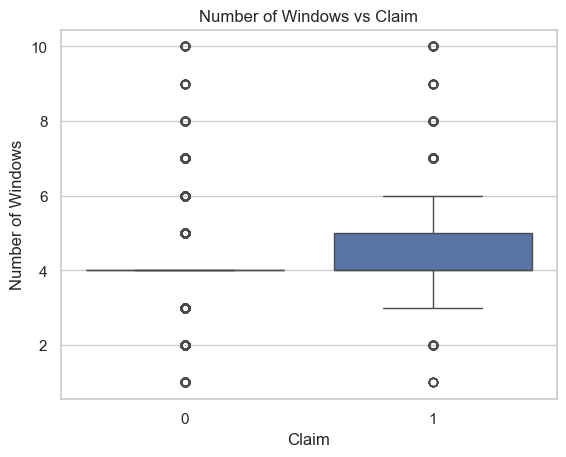

In [185]:
data["NumberOfWindows"] = pd.to_numeric(
    data["NumberOfWindows"], errors="coerce"
)

plt.figure()
sns.boxplot(x="Claim", y="NumberOfWindows", data=data)
plt.title("Number of Windows vs Claim")
plt.xlabel("Claim")
plt.ylabel("Number of Windows")
plt.show()


##### 8.  Claim Rate by Property Protection Features

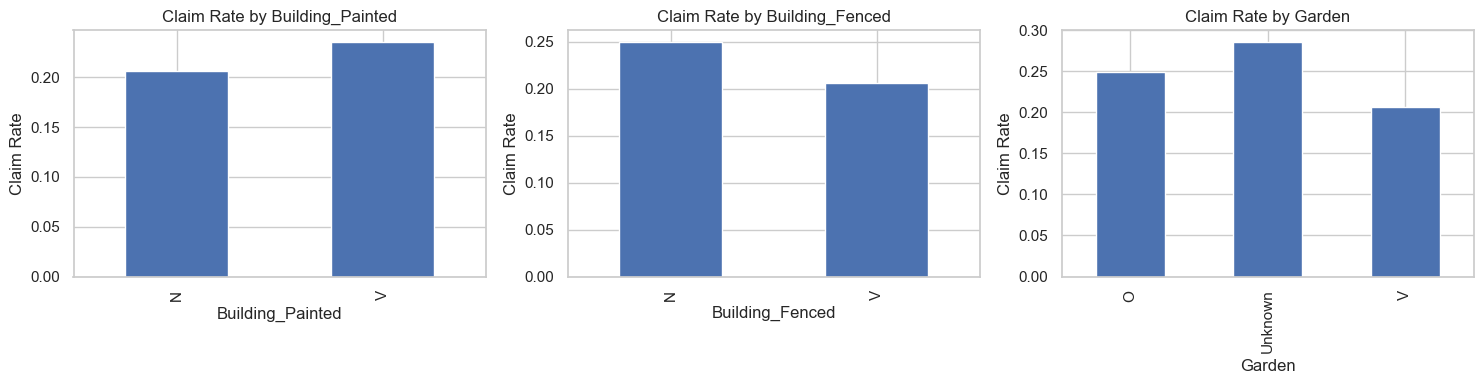

In [36]:
features = ["Building_Painted", "Building_Fenced", "Garden"]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, feature in enumerate(features):
    rate = data.groupby(feature)["Claim"].mean()
    rate.plot(kind="bar", ax=axes[i])
    axes[i].set_title(f"Claim Rate by {feature}")
    axes[i].set_ylabel("Claim Rate")

plt.tight_layout()
plt.show()

# Building_Painted": N= Painted,  V= Not painted
# Building Fenced: N = Fenced, Not Fenced
# Garden : V = Has garden, N= Has no garden

##### 9. Claim Rate by Geographic Code

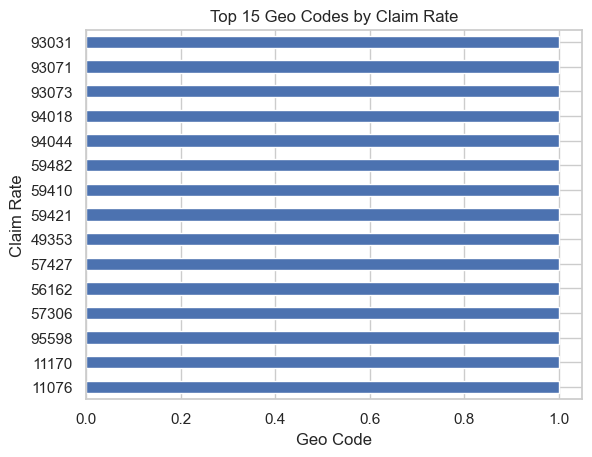

In [187]:
geo_claim = (
    data.groupby("Geo_Code")["Claim"]
    .mean()
    .sort_values(ascending=False)
    .head(15)
)

plt.figure()
geo_claim.plot(kind="barh")
plt.title("Top 15 Geo Codes by Claim Rate")
plt.ylabel("Claim Rate")
plt.xlabel("Geo Code")
plt.show()


##### 10. Claim  by Geographic Code

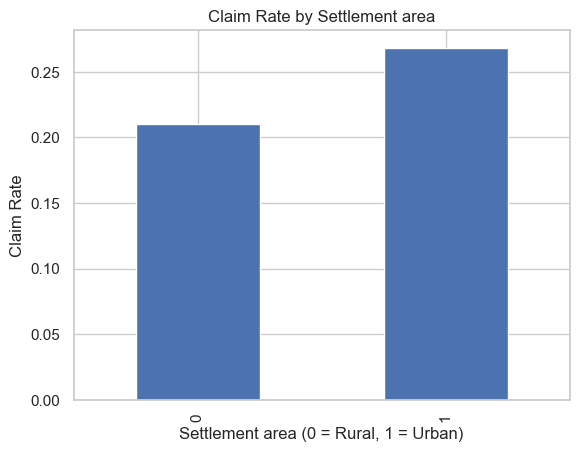

In [188]:
Set_claim = data.groupby("Settlement")["Claim"].mean()

plt.figure()
res_claim.plot(kind="bar")
plt.title("Claim Rate by Settlement area")
plt.ylabel("Claim Rate")
plt.xlabel("Settlement area (0 = Rural, 1 = Urban)")
plt.show()

#### Statistical operations

In [189]:
data["Insured_Period"].mean()

np.float64(0.9097577429115922)

In [192]:
# Grouping the data based on the target variable
data.groupby("Claim").mean(numeric_only=True)

,YearOfObservation,Insured_Period,Residential,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Age_of_house
Claim,,,,,,,,
0,2013.681868,0.898193,0.289540,1520.758415,2.128664,1964.078906,4.037097,49.576004
1,2013.627907,0.948870,0.359241,3111.264994,2.380049,1965.718016,4.608935,47.987760


#### Validate target variable


In [ ]:
Exploratory Data Analysis (EDA)
a) Claim vs non-claim comparison

In [15]:
claim_counts=data["Claim"].value_counts()
# 1---> Had at least one claim
# 0---> Building had no claim
print(claim_counts)

Claim
0    5526
1    1634
Name: count, dtype: int64


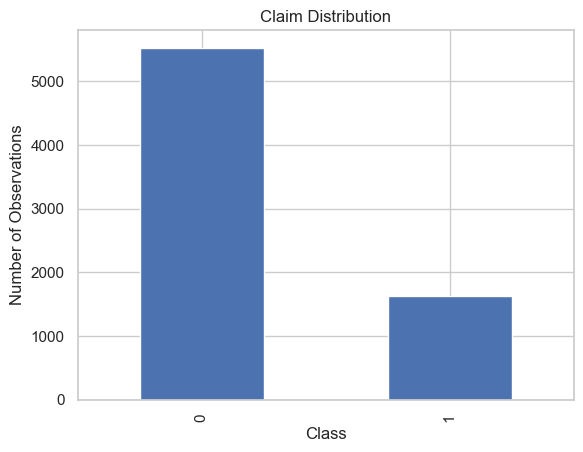

In [190]:
# Plotting status counts
claim_counts.plot(kind='bar')
plt.title("Claim Distribution")
plt.ylabel("Number of Observations")
plt.xlabel("Class")
plt.show()


In [191]:
# Examining for balance in datasets
# Percentage of each class
class_percentages = data['Claim'].value_counts(normalize=True) * 100

balance_df = pd.DataFrame({
    'Count': claim_counts,
    'Percentage (%)': class_percentages.round(2)
})

balance_df
# This shows that the minority class (buildings with claims are 22% of the dataset, moderate imbalance)

,Count,Percentage (%)
Claim,,
0,5526,77.18
1,1634,22.82


In [ ]:
#  Explanation: This is moderate imbalance
# Implication: Using accuracy as the only metircs for model performance becomes misleading and precison and recall should be deployed in addition, unless class weight is used.

#### Data PreProcessing

##### Separating the features and target

In [39]:
X = data.drop(columns=["Customer Id", "YearOfObservation", "Date_of_Occupancy","Claim"])
y = data["Claim"]

##### Splitting of data

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=23)

##### Delineating numerical and categorical features

In [44]:
numeric_features = X_train.select_dtypes(include=np.number).columns
categorical_features = X_train.select_dtypes(exclude=np.number).columns

##### Using a pipeline for scaling, encoding (turning categorigal into numeric)

### Model training

In [59]:

# PREPROCESSING
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])


# FEATURE SELECTION

lasso_selector = SelectFromModel(
    LogisticRegression(
        penalty="l1",
        solver="liblinear",
        max_iter=500
    )
)

tree_selector = SelectFromModel(
    RandomForestClassifier(
        n_estimators=100,
        random_state=42
    )
)

rfe_selector = RFE(
    estimator=LogisticRegression(max_iter=500),
    n_features_to_select=10
)

# PIPELINES PRODUCTION FOR DIFFERENT MODELS

pipelines = {

    "Ridge": Pipeline([
        ("preprocess", preprocessor),
        ("feature_selection", lasso_selector),
        ("model", RidgeClassifier())
    ]),

    "Lasso_Logistic": Pipeline([
        ("preprocess", preprocessor),
        ("model", LogisticRegression(
            penalty="l1",
            solver="liblinear",
            max_iter=500
        ))
    ]),

    "Logistic": Pipeline([
        ("preprocess", preprocessor),
        ("feature_selection", lasso_selector),
        ("model", LogisticRegression(max_iter=500))
    ]),

    "DecisionTree": Pipeline([
        ("preprocess", preprocessor),
        ("model", DecisionTreeClassifier(random_state=42))
    ]),

    "KNN": Pipeline([
        ("preprocess", preprocessor),
        ("feature_selection", rfe_selector),
        ("model", KNeighborsClassifier(n_neighbors=5))
    ]),

    "RandomForest": Pipeline([
        ("preprocess", preprocessor),
        ("feature_selection", tree_selector),
        ("model", RandomForestClassifier(
            n_estimators=200,
            random_state=42
        ))
    ]),

    "XGBoost": Pipeline([
        ("preprocess", preprocessor),
        ("model", XGBClassifier(
            eval_metric="logloss",
            random_state=42
        ))
    ]),

    "SVM": Pipeline([
        ("preprocess", preprocessor),
        ("feature_selection", rfe_selector),
        ("model", SVC(probability=True))
    ])
}

# FITTING  & PREDICTION

for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    print(f"{name}: predictions generated")


Ridge: predictions generated
Lasso_Logistic: predictions generated
Logistic: predictions generated
DecisionTree: predictions generated
KNN: predictions generated
RandomForest: predictions generated
XGBoost: predictions generated
SVM: predictions generated


In [60]:
from sklearn.model_selection import cross_val_score

for name, pipe in pipelines.items():
    scores = cross_val_score(
        pipe, X_train, y_train,
        cv=5,
        scoring="roc_auc"
    )
    print(f"{name}: Mean ROC-AUC = {scores.mean():.4f}")


Ridge: Mean ROC-AUC = 0.6949
Lasso_Logistic: Mean ROC-AUC = 0.7091
Logistic: Mean ROC-AUC = 0.7030
DecisionTree: Mean ROC-AUC = 0.5811
KNN: Mean ROC-AUC = 0.5063
RandomForest: Mean ROC-AUC = 0.6760
XGBoost: Mean ROC-AUC = 0.7009
SVM: Mean ROC-AUC = 0.5068


In [71]:

for name, pipe in pipelines.items():
    print(f"--- {name} ---")
    
    #  Cross-validated ROC-AUC using cross_val_score
    try:
        roc_auc = cross_val_score(pipe, X_train, y_train, cv=5, scoring='roc_auc')
        print(f"Mean ROC-AUC (cross_val_score): {roc_auc.mean():.4f}")
    except Exception as e:
        print(f"ROC-AUC (cross_val_score) error: {e}")
    
    #  Get predicted labels (out-of-fold predictions)
    y_pred = cross_val_predict(pipe, X_train, y_train, cv=5)
    
    #  Get predicted scores for ROC-AUC
    try:
        # Prefer predict_proba
        y_scores = cross_val_predict(pipe, X_train, y_train, cv=5, method='predict_proba')[:, 1]
    except AttributeError:
       # If not available
        y_scores = cross_val_predict(pipe, X_train, y_train, cv=5, method='decision_function')
    
    #  Metrics
    precision = precision_score(y_train, y_pred)
    recall = recall_score(y_train, y_pred)
    clf_report = classification_report(y_train, y_pred)
    conf_matrix = confusion_matrix(y_train, y_pred)
    auc_score = roc_auc_score(y_train, y_scores)
    
    #  Print results
    print(f"ROC-AUC (cross_val_predict scores): {auc_score:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("Classification Report:")
    print(clf_report)
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\n")


--- Ridge ---
Mean ROC-AUC (cross_val_score): 0.6949
ROC-AUC (cross_val_predict scores): 0.6949
Precision: 0.5502
Recall: 0.1733
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.96      0.87      4401
           1       0.55      0.17      0.26      1327

    accuracy                           0.78      5728
   macro avg       0.67      0.57      0.57      5728
weighted avg       0.74      0.78      0.73      5728

Confusion Matrix:
[[4213  188]
 [1097  230]]


--- Lasso_Logistic ---
Mean ROC-AUC (cross_val_score): 0.7092
ROC-AUC (cross_val_predict scores): 0.7087
Precision: 0.6040
Recall: 0.1839
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.96      0.87      4401
           1       0.60      0.18      0.28      1327

    accuracy                           0.78      5728
   macro avg       0.70      0.57      0.58      5728
weighted avg       0.75      0.78      0.

##### Retraining logistic regression since it had the best accuracy

In [77]:
# Ensure numeric columns are truly numeric
for col in num_cols:
    X_train[col] = pd.to_numeric(X_train[col], errors="coerce")
    X_test[col] = pd.to_numeric(X_test[col], errors="coerce")


In [78]:
# Then fill missing numeric values:
X_train[num_cols] = X_train[num_cols].fillna(0)  # or mean, median
X_test[num_cols] = X_test[num_cols].fillna(0)


In [82]:
# Update ColumnTransformer to dense output (to avoid sparse and numeric pass through issues)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False), cat_cols)
    ]
)


In [80]:
lasso_logistic = Pipeline([
    ("preprocess", preprocessor),
    ("model", LogisticRegression(penalty="l1", solver="liblinear", max_iter=1000))
])

In [81]:
#sparse_output=False ensures the transformer outputs a dense NumPy array, compatible with LogisticRegression.
lasso_logistic.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [83]:
# Predict probabilities:
y_prob = lasso_logistic.predict_proba(X_test)[:,1]


In [84]:
# # ROC-AUC
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC–AUC:", roc_auc)


ROC–AUC: 0.6806847629388347


In [86]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score
# Model struggles a bit with minority class
# PR-AUC
pr_auc = average_precision_score(y_test, y_prob)
print("PR–AUC:", pr_auc)


PR–AUC: 0.3935840697372542


In [ ]:
# Handle class imbalance
# Option A: Class weighting

In [87]:
from sklearn.linear_model import LogisticRegression

lasso_logistic = Pipeline([
    ("preprocess", preprocessor),
    ("model", LogisticRegression(
        penalty="l1",
        solver="liblinear",
        max_iter=1000,
        class_weight="balanced"  # automatically weights minority class higher
    ))
])


In [91]:
from sklearn.model_selection import GridSearchCV

param_grid = {"model__C": [0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(lasso_logistic, param_grid, cv=5, scoring="average_precision")
grid.fit(X_train, y_train)

print("Best C:", grid.best_params_)


Best C: {'model__C': 0.1}


In [92]:
lasso_logistic_final = Pipeline([
    ("preprocess", preprocessor),
    ("model", LogisticRegression(
        penalty="l1",
        solver="liblinear",
        C=0.1,              # 👈 plug it in here
        max_iter=1000,
        class_weight="balanced"  # keep if you used it
    ))
])

lasso_logistic_final.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [94]:
# Predict probabilities:
y_prob_final = lasso_logistic_final.predict_proba(X_test)[:,1]

In [95]:
# # ROC-AUC
roc_auc = roc_auc_score(y_test, y_prob_final)
print("ROC–AUC:", roc_auc)


ROC–AUC: 0.7014390155627941


In [96]:
pr_auc = average_precision_score(y_test, y_prob_final)
print("PR–AUC:", pr_auc)

PR–AUC: 0.41612224378746904


In [ ]:
# After tuning the logistic regression model with C = 0.1, increased by 2 for the ability to detect 